In [2]:
import pickle
import gzip
import argparse
import os
import sys
from torch.distributions.categorical import Categorical

sys.path.append('../../')
from guacamol.utils.helpers import setup_default_logger

from smiles_rnn_distribution_learner import SmilesRnnDistributionLearner

setup_default_logger()

parser = argparse.ArgumentParser(description='Distribution learning benchmark for SMILES RNN',
                                 formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument('--train_data', default='../../data/QM9/QM9_clean_smi_train_smile.npz',
                    help='Full path to SMILES file containing training data')
parser.add_argument('--valid_data', default='../../data/QM9/QM9_clean_smi_test_smile.npz',
                    help='Full path to SMILES file containing validation data')
parser.add_argument('--prop_model', default="../../data/QM9/prior.pkl.gz", help='Saved model for properties distribution')    
parser.add_argument('--output_dir', default='./output/Qm9/', help='Output directory')

parser.add_argument('--batch_size', default=512, type=int, help='Size of a mini-batch for gradient descent')
parser.add_argument('--valid_every', default=1000, type=int, help='Validate every so many batches')
parser.add_argument('--print_every', default=10, type=int, help='Report every so many batches')
parser.add_argument('--n_epochs', default=10, type=int, help='Number of training epochs')
parser.add_argument('--max_len', default=280, type=int, help='Max length of a SMILES string')
parser.add_argument('--hidden_size', default=512, type=int, help='Size of hidden layer')
parser.add_argument('--n_layers', default=3, type=int, help='Number of layers for training')
parser.add_argument('--rnn_dropout', default=0.2, type=float, help='Dropout value for RNN')
parser.add_argument('--lr', default=1e-3, type=float, help='RNN learning rate')
parser.add_argument('--seed', default=42, type=int, help='Random seed')

args,_ = parser.parse_known_args()

args.batch_size = 6



In [3]:
# 1. lprepare the training and validation data
import numpy as np 
import random 
from rnn_utils import get_tensor_dataset, load_smiles_and_properties, set_random_seed

if args.output_dir is None:
    args.output_dir = os.path.dirname(os.path.realpath(__file__))
   
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)
     
        

prop_model = pickle.load(gzip.open(args.prop_model))



training_set=args.train_data
validation_set=args.valid_data
max_len = 100
train_seqs, train_prop = load_smiles_and_properties(training_set, max_len)
sample_indexs = np.arange(train_seqs.shape[0])
random.shuffle(sample_indexs)
train_x, train_y = train_seqs[sample_indexs[10000:],:], train_prop[sample_indexs[10000:],:]
valid_x, valid_y = train_seqs[sample_indexs[:10000],:], train_prop[sample_indexs[:10000],:]

if prop_model is not None:
    train_y = prop_model.transform(train_y)
    valid_y = prop_model.transform(valid_y)
    
    
train_set = get_tensor_dataset(train_x, train_y)
valid_set = get_tensor_dataset(valid_x, valid_y)

In [4]:
from torch.utils.data import DataLoader
import torch
import logging

PROPERTY_SIZE = 9
hidden_size=512
n_layers=3
rnn_dropout=0.2
batch_size=6
num_workers=0


cuda_available = torch.cuda.is_available()
device_str = 'cuda' if cuda_available else 'cpu'
device = torch.device(device_str)

set_random_seed(42, device)


data_loader = DataLoader(train_set,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=num_workers,
                                 pin_memory=True)

for batch_index, batch_all in enumerate(data_loader):
    batch = batch_all[:-1]
    properties = batch_all[-1].to(device)
    inp, tgt = batch

In [5]:
from scipy.spatial.distance import cdist
K = cdist(properties, torch.tensor(train_y).float(), metric='euclidean')

1. sample according to knn 

In [6]:
sample_size = 10
selected = np.argsort(K, axis=1)[:,:sample_size]

In [7]:
selected.shape

(5, 10)

In [7]:
properties[0,:]

tensor([-1.5999, -0.4318,  0.2557, -0.5177, -0.9237,  0.6546, -0.1682,
         0.8152,  0.6067], device='cuda:0')

In [8]:
train_y[selected[0,0],:]

array([-1.59989955, -0.43184623,  0.25568422, -0.51772474, -0.92373615,
        0.65461782, -0.16818697,  0.81516874,  0.60673663])

In [12]:
train_y[selected[0,1],:]

array([-1.34049748, -0.2083466 ,  0.27714319, -0.52015953, -0.76480597,
        0.57043644, -0.39001386,  1.03966174,  0.36786741])

In [14]:
K.shape

(5, 113885)

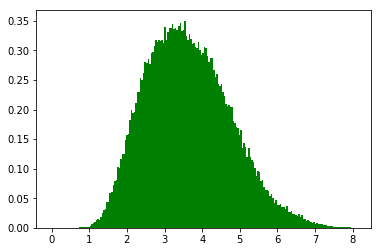

In [16]:
import matplotlib.pyplot as plt
plt.hist(K[0,:],200, density=True, facecolor='g')
plt.show()

In [10]:
K[selected]

IndexError: index 29658 is out of bounds for axis 0 with size 5

In [11]:
selected.shape

(5, 10)